In [68]:
import os
import pickle
from itertools import combinations
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys
sys.path.append("..")
import multidms
from timeit import default_timer as timer
import importlib

In [69]:
# results

### Globals

In [70]:
exp_name = None #"clip_search"
substitution_column = 'aa_substitutions_reference'
experiment_column = 'homolog_exp'
scaled_func_score_column = 'log2e'

In [71]:
fit_params = {
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : None, # 10000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "func_score_target" : 'func_score', # 'log2e',
    "experiment_ref" : 'Delta-2-1',
    "experiment_2" : 'Omicron_BA.1-2-1',
    "shift_func_score_target_nonref" : False, #-1,# None, -1,
    "warmup_to_ref" : False,
    "maxiter" : 10000,
    "λ_lasso" : 1e-5,
    "λ_ridge" : 0,
    "model" : "non-linear"
}

In [72]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)

In [73]:
# ! rm results.pkl

In [74]:
# if not os.path.exists(f"{exp_name}.pkl"):
#     cols = list(fit_params.keys()) + [
#         "tuned_model_params", "all_subs", "variant_prediction_df"
#     ]
#     results = pd.DataFrame(columns = cols)
# else:
#     results = pickle.load(open(f"{exp_name}.pkl", "rb"))

In [75]:
if fit_params["experiment_2"]:
    func_score_data = func_score_data.query(
        f"{experiment_column}.isin(['{fit_params['experiment_ref']}', '{fit_params['experiment_2']}'])"
    )

In [76]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

In [78]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/182229 [00:00<?, ?it/s]

In [79]:
# TODO re-write and make function
# def normalize_by_freq()?
dfs = []
for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
    n_post_counts = sum(hdf['post_count'])
    if 'Delta' in h:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    else:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    hdf['orig_post_count'] = hdf['post_count']
    hdf['post_count'] *= scaling_factor
    hdf['post_count_wt'] *= scaling_factor
    print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

    # Recompute enrichment ratios with new counts
    hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
    hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
    hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
    hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

    total_pre_count = sum(hdf['pre_count_ps'])
    total_post_count = sum(hdf['post_count_ps'])

    hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
    hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
    hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
    hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

    hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
    hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
    hdf['e'] = hdf['var_e'] / hdf['wt_e']
    #hdf.dropna(subset=['e'], inplace=True)
    hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
    dfs.append(hdf)
func_score_df = pd.concat(dfs)

Delta-2-1 14446779 0.01 100000.0
Omicron_BA.1-2-1 60830459 0.0 100000.0


In [80]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
#     print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

In [81]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
func_score_df["post_count"] = func_score_df["post_count"].astype(int)

In [82]:
# TODO, what's the order of operations?
if fit_params["shift_func_score_target_nonref"]:
    h2_idx = func_score_df.query(f"{experiment_column} == '{fit_params['experiment_2']}'").index
    func_score_df.loc[h2_idx, fit_params["func_score_target"]] += fit_params["shift_func_score_target_nonref"]

In [83]:
if fit_params['clip_target']:
    tar = fit_params["func_score_target"]
    func_score_df[tar] = func_score_df[tar].clip(*fit_params["clip_target"])

In [84]:
importlib.reload(multidms.utils)

<module 'multidms.utils' from '/home/jgallowa/Projects/multidms/notebooks/../multidms/utils.py'>

In [101]:
cols = list(fit_params.keys()) + [
    "tuned_model_params", "all_subs", "variant_prediction_df", "site_map"
]
results = pd.DataFrame(columns = cols)

In [86]:
# multidms = importlib.reload(multidms)
(X, y), df, all_subs, site_map = multidms.utils.create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            fit_params["experiment_ref"],
                            substitution_column,
                            fit_params["func_score_target"]
                        )

sig_upper = df[fit_params["func_score_target"]].quantile(0.95)
sig_lower = df[fit_params["func_score_target"]].quantile(0.05)
sig_range = sig_upper - sig_lower

Found 11 site(s) lacking data in at least one homolog.
2766 of the 93822 variants were removed because they had mutations at the above sites, leaving 91056 variants.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 66785/66785 [02:11<00:00, 507.30it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-2-1.


In [130]:
# fit_params["maxiter"] = 10000
fit_params["model"] = "linear"

In [131]:
# Initialize all params
params = multidms.utils.initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[fit_params["experiment_ref"]].shape[1],
    include_alpha=True if fit_params["model"] == "non-linear" else False,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [132]:
params

{'β': DeviceArray([ 1.83095432, -0.50997419,  0.79581333, ..., -0.14361239,
              -0.20343108, -1.30266273], dtype=float64),
 'S_Delta-2-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta-2-1': DeviceArray([0.], dtype=float64),
 'γ_Delta-2-1': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA.1-2-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA.1-2-1': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA.1-2-1': DeviceArray([0.], dtype=float64),
 'C_ref': DeviceArray([5.], dtype=float64)}

In [133]:
importlib.reload(multidms.model)
if fit_params["model"] == "non-linear":
    cost_func = multidms.model.cost_smooth
    prox_func = multidms.model.prox
    pred_func = multidms.model.f 
else:
    cost_func = multidms.model.cost_smooth_linear
    prox_func = multidms.model.prox_linear
    pred_func = multidms.model.f_linear 

In [134]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_func(params, (X, y), λ_ridge=fit_params['λ_ridge']):.2e}")

tol = 1e-6
maxiter = fit_params['maxiter']
start = timer()

solver = ProximalGradient(cost_func, prox_func, tol=tol, maxiter=maxiter)

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params = {
            f"S_{fit_params['experiment_2']}" : fit_params['λ_lasso']
        },
        lock_params = {
            f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
            f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
            f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,)),
            f"γ_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge']
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_func(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")
print(f"\nDONE :)")
print(f"-------------------")


Pre-Optimization
----------------
cost = 1.14e+01
Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 6.84e-04
cost = 6.08e-01
Wall time for fit: 127.53174166940153

DONE :)
-------------------


In [135]:
for param in ["β", f"S_{fit_params['experiment_2']}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)

    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)

    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")

for param, value in params.items():
    if param in ["β", f"S_{fit_params['experiment_ref']}", f"S_{fit_params['experiment_2']}"]: continue
    print(f"{param}: {value}")
    print()

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{fit_params['func_score_target']}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(experiment_column):
    
    h_params = {
#         "α":params["α"],
        "β":params["β"], 
        "C_ref":params["C_ref"],
        "S":params[f"S_{homolog}"], 
        "C":params[f"C_{homolog}"],
        "γ":params[f"γ_{homolog}"]
    }
    if fit_params["model"] == "non-linear": h_params["α"] = params["α"]
    
    z_h = multidms.model.ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h

    y_h_pred = pred_func(h_params, X[homolog])
    df.loc[hdf.index, f"predicted_{fit_params['func_score_target']}"] = y_h_pred
    
print(f"\nDONE :)")
print(f"-------------------")

row = fit_params.copy()
row["tuned_model_params"] = params.copy()
row["all_subs"] = all_subs.copy()
row["variant_prediction_df"] = df.drop("index", axis=1)
row["site_map"] = site_map.copy()

# results = pd.Series(row)
results.loc[len(results)] = pd.Series(row)


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -5.87e-01
Median = -3.16e-01
Measures of Dispersion
Minimum = -5.00e+00
Maximum = 6.46e+00
Range = 1.15e+01
Variance = 1.10e+00
Standard Deviation = 1.05e+00

Fit S_Omicron_BA.1-2-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.16e-01
Median = 0.00e+00
Measures of Dispersion
Minimum = -6.21e+00
Maximum = 4.00e+00
Range = 1.02e+01
Variance = 4.01e-01
Standard Deviation = 6.33e-01
C_Delta-2-1: [0.]

C_Omicron_BA.1-2-1: [0.]

C_ref: [-0.15753472]

γ_Delta-2-1: [0.]

γ_Omicron_BA.1-2-1: [-2.52294053]


Running Predictions
-------------------

DONE :)
-------------------


In [137]:
results

,fs_scaling_group_column,min_pre_counts,pseudocount,agg_variants,sample,clip_target,func_score_target,experiment_ref,experiment_2,shift_func_score_target_nonref,warmup_to_ref,maxiter,λ_lasso,λ_ridge,model,tuned_model_params,all_subs,variant_prediction_df,site_map
0,homolog_exp,100,0.1,True,None,"(-3.5, 2.5)",func_score,Delta-2-1,Omicron_BA.1-2-1,False,False,10000,0.00001,0,non-linear,"{'C_Delta-2-1': [0.0], 'C_Omicron_BA.1-2-1': [...","[M1F, M1I, M1K, M1L, M1T, M1V, F2I, F2L, F2S, ...",aa_substitutions_reference homol...,Delta-2-1 Omicron_BA.1-2-1 1015 A...
1,homolog_exp,100,0.1,True,None,"(-3.5, 2.5)",func_score,Delta-2-1,Omicron_BA.1-2-1,False,False,10000,0.00001,0,non-linear,"{'C_Delta-2-1': [0.0], 'C_Omicron_BA.1-2-1': [...","[M1F, M1I, M1K, M1L, M1T, M1V, F2I, F2L, F2S, ...",aa_substitutions_reference homol...,Delta-2-1 Omicron_BA.1-2-1 1015 A...
2,homolog_exp,100,0.1,True,None,"(-3.5, 2.5)",func_score,Delta-2-1,Omicron_BA.1-2-1,False,False,10000,0.00001,0,linear,"{'C_Delta-2-1': [0.0], 'C_Omicron_BA.1-2-1': [...","[M1F, M1I, M1K, M1L, M1T, M1V, F2I, F2L, F2S, ...",aa_substitutions_reference homol...,Delta-2-1 Omicron_BA.1-2-1 1015 A...


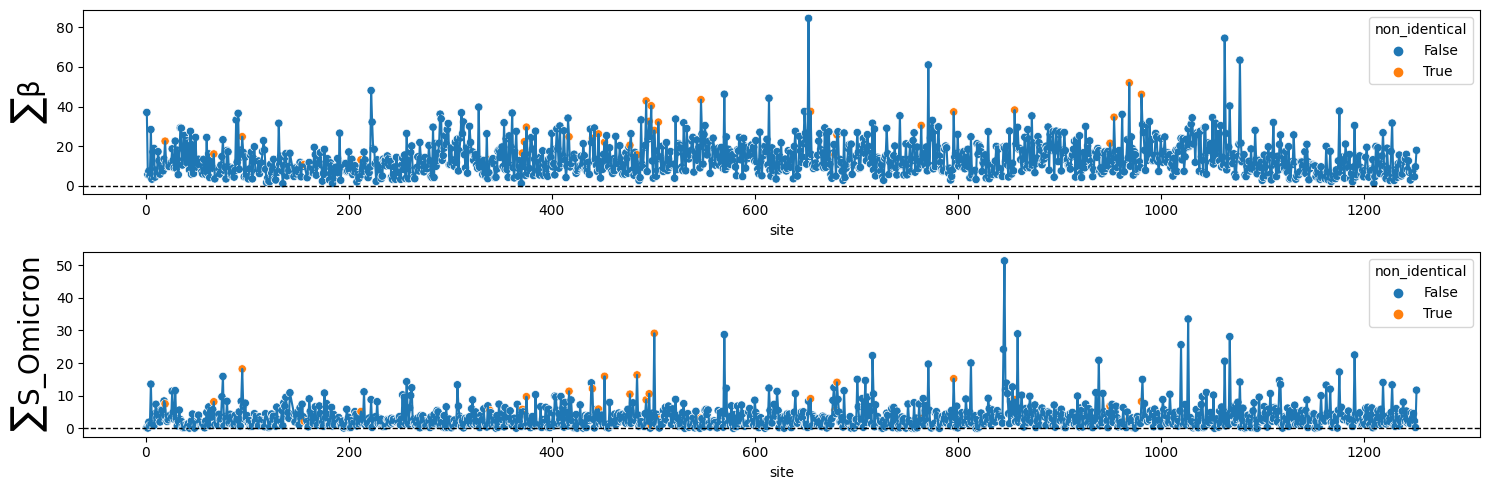

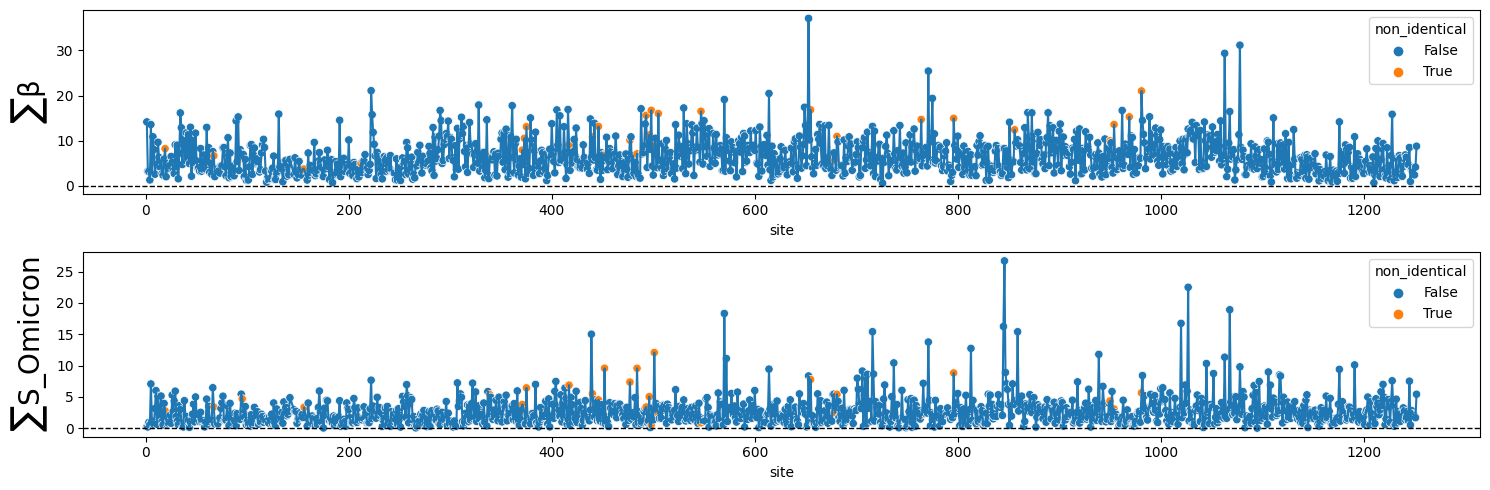

In [159]:
importlib.reload(multidms.plot)
res = results.loc[1:, :]
# multidms.plot.plot_pred_scatter(
#     res, 
#     annotation_vars=list(fit_params.keys()), 
#     hue=True, 
#     printrow=False,
#     annotate_params=True,
# )
# multidms.plot.plot_param_hist(
#     res,
#     printrow=False
# )
# multidms.plot.plot_param_heatmap(
#     res, 
#     printrow=False
# )
multidms.plot.plot_shift_by_site(
    res, 
    printrow=False
)
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     idx_1=1, idx_2=2
# )